# Deep Learning for Computer Vision: Assignment
* Group: MH
* Name: Hanh Ngo-Minh
* Student ID: 1810908

In this assignment, the chosen paper to be implemented will be: "**ResT: An Efficient Transformer for Visual Recognition**"

This paper presents an efficient multi-scale vision Transformer, called ResT, that capably served as a general-purpose backbone for image recognition. Unlike existing Transformer methods, which employ standard Transformer blocks to tackle raw images with a fixed resolution, our ResT have several advantages:
1. A memory-efficient multi-head self-attention is built, which compresses the memory by a simple depth-wise convolution, and projects the interaction across the attention-heads dimension while keeping the diversity ability of multi-heads;
2. Position encoding is constructed as spatial attention, which is more flexible and can tackle with input images of arbitrary size without interpolation or fine-tune;
3. Instead of the straightforward tokenization at the beginning of each stage, we design the patch embedding as a stack of overlapping convolution operation with stride on the 2D-reshaped token map.

## Install and import neccessary libraries

In [1]:
!pip install timm

In [2]:
import torch
import torch.nn as nn

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

## Model Implementation

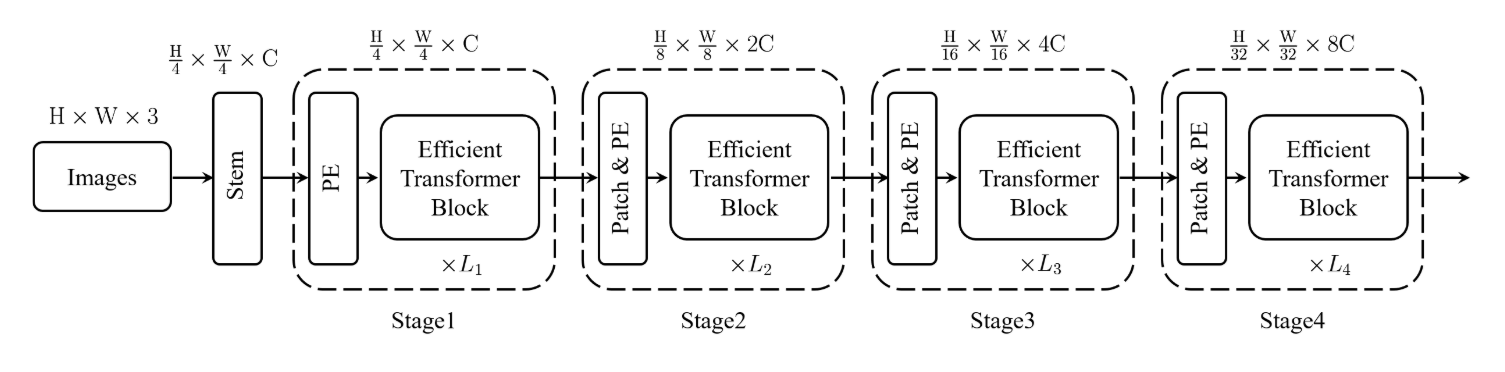

Figure 1. The pipeline of ResT backbone

### Pipeline Structure
Similar to ResNet, ResT employs a hierarchical structure for feature extraction - the initial processing block, similar to ResNet's stem, extracts low-level features from the input image.

There are four stages total to capture multi-scale feature maps. Each stage consists of three components:
* Patch Embedding (or Stem): This module reduces the input resolution (similar to the initial stem module) while increasing the channel dimension, essentially transforming the image into tokens.
* Positional Encoding: This module injects information about the relative positions of the tokens within the feature map, crucial for the Transformer blocks. (ResT utilizes spatial attention for this purpose, unlike standard Transformers that use learned positional encoding.)
* Efficient Transformer Blocks (L blocks per stage): These blocks process the feature maps, capturing complex relationships between tokens. ResT utilizes efficient variants of Transformer blocks to reduce computational cost.

### Efficient Transformer Block

Standard MSA (Multi-Head Self-Attention) has some shortcomings:
* High Computational Cost: MSA suffers from a quadratic computational complexity with respect to the input token dimension ($d_m$) or sequence length ($n$). This means the processing time increases significantly as the number of tokens or the embedding dimension grows. This can lead to:
  * Slower Training: Training large models with large datasets becomes computationally expensive.
  * Limited Inference Speed: Real-time applications might be hindered by the high computational demands.
* Limited Representation Learning with Small Head Dimension: When the embedding dimension per head (resulting from dividing the full embedding dimension d_model by the number of heads $h$) is small, each MSA head might struggle to capture complex relationships between tokens. This can potentially limit the model's overall performance, especially when dealing with tasks requiring rich contextual information.

To significantly improve the computational efficiency of multi-head self-attention, ResT presents a novel and efficient multi-head self-attention module as below.

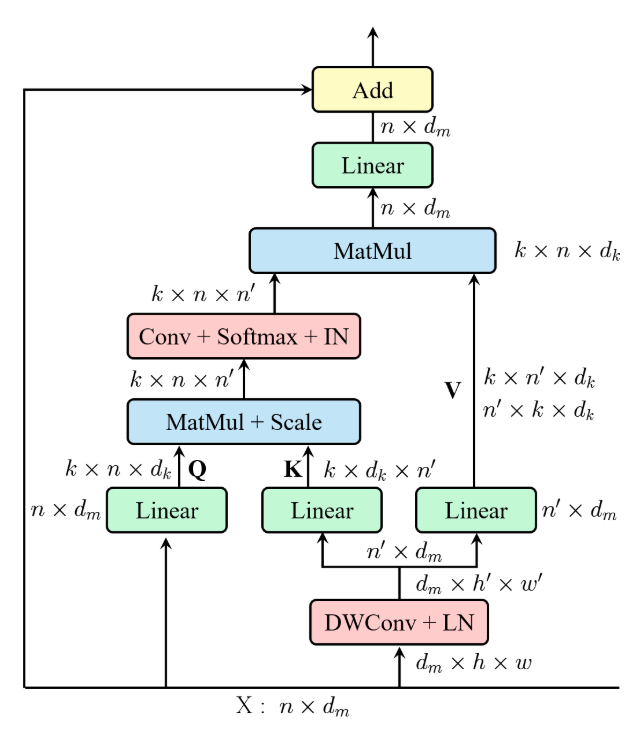

Figure 2. Efficient Multi-Head Self-Attention

In [3]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [4]:
class Attention(nn.Module):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.,
                 sr_ratio=1,
                 apply_transform=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio + 1, stride=sr_ratio, padding=sr_ratio // 2, groups=dim)
            self.sr_norm = nn.LayerNorm(dim)

        self.apply_transform = apply_transform and num_heads > 1
        if self.apply_transform:
            self.transform_conv = nn.Conv2d(self.num_heads, self.num_heads, kernel_size=1, stride=1)
            self.transform_norm = nn.InstanceNorm2d(self.num_heads)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.sr_norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, N, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        if self.apply_transform:
            attn = self.transform_conv(attn)
            attn = attn.softmax(dim=-1)
            attn = self.transform_norm(attn)
        else:
            attn = attn.softmax(dim=-1)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [5]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, apply_transform=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio, apply_transform=apply_transform)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

### Positional Encoding & Patch Embedding
**Positional Encoding:**
* Standard Transformer:
  * Relies on learned positional encoding added to the input token embeddings. This encoding helps the model understand the relative position of tokens within the sequence.
  * This approach can be computationally expensive and limits the model's ability to handle sequences of arbitrary length.
* ResT Backbone:
  * Employs a technique called "spatial attention" as its positional encoding. This leverages the inherent spatial relationships within images during the convolutional operations in the backbone.
  * Eliminates the need for learned positional encoding, reducing computational cost.
  * Allows ResT to handle images of any size without requiring specific preprocessing or modifications for different input resolutions.

**Patch Embedding:**
* Standard Transformer:
  * Typically processes entire images as a single sequence. This might not be optimal for capturing local features effectively, especially for high-resolution images.
  * Patch embedding breaks down the image into smaller patches, which are then embedded into lower-dimensional vectors. This allows the model to focus on specific local features within the image.
* ResT Backbone:
  * Utilizes a convolutional layer with a stride equal to the patch size for patch extraction, similar to standard Transformer patch embedding.
  * However, ResT's convolutional patch embedding might benefit from the inherent feature extraction capabilities of convolutions, potentially leading to better local feature representation compared to a simple linear projection used in some Transformer architectures.

In [6]:
class PA(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.pa_conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(self.pa_conv(x))

In [7]:
class GL(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gl_conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)

    def forward(self, x):
        return x + self.gl_conv(x)

In [8]:
class PatchEmbed(nn.Module):
    def __init__(self, patch_size=16, in_ch=3, out_ch=768, with_pos=False):
        super().__init__()
        self.patch_size = to_2tuple(patch_size)
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=patch_size + 1, stride=patch_size, padding=patch_size // 2)
        self.norm = nn.BatchNorm2d(out_ch)

        self.with_pos = with_pos
        if self.with_pos:
            self.pos = PA(out_ch)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        x = self.norm(x)
        if self.with_pos:
            x = self.pos(x)
        x = x.flatten(2).transpose(1, 2)
        H, W = H // self.patch_size[0], W // self.patch_size[1]
        return x, (H, W)

In [9]:
class BasicStem(nn.Module):
    def __init__(self, in_ch=3, out_ch=64, with_pos=False):
        super(BasicStem, self).__init__()
        hidden_ch = out_ch // 2
        self.conv1 = nn.Conv2d(in_ch, hidden_ch, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=False)

        self.act = nn.ReLU(inplace=True)
        self.with_pos = with_pos
        if self.with_pos:
            self.pos = PA(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)

        x = self.conv3(x)
        if self.with_pos:
            x = self.pos(x)
        return x

In [10]:
class Stem(nn.Module):
    def __init__(self, in_ch=3, out_ch=64, with_pos=False):
        super(Stem, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.with_pos = with_pos
        if self.with_pos:
            self.pos = PA(out_ch)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.max_pool(x)

        if self.with_pos:
            x = self.pos(x)
        return x

### ResT

In [11]:
class ResT(nn.Module):
    def __init__(self, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False,
                 qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
                 norm_layer=nn.LayerNorm, apply_transform=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.apply_transform = apply_transform

        self.stem = BasicStem(in_ch=in_chans, out_ch=embed_dims[0], with_pos=True)

        self.patch_embed_2 = PatchEmbed(patch_size=2, in_ch=embed_dims[0], out_ch=embed_dims[1], with_pos=True)
        self.patch_embed_3 = PatchEmbed(patch_size=2, in_ch=embed_dims[1], out_ch=embed_dims[2], with_pos=True)
        self.patch_embed_4 = PatchEmbed(patch_size=2, in_ch=embed_dims[2], out_ch=embed_dims[3], with_pos=True)

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        self.stage1 = nn.ModuleList([
            Block(embed_dims[0], num_heads[0], mlp_ratios[0], qkv_bias, qk_scale, drop_rate, attn_drop_rate,
                  drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[0], apply_transform=apply_transform)
            for i in range(self.depths[0])])

        cur += depths[0]
        self.stage2 = nn.ModuleList([
            Block(embed_dims[1], num_heads[1], mlp_ratios[1], qkv_bias, qk_scale, drop_rate, attn_drop_rate,
                  drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[1], apply_transform=apply_transform)
            for i in range(self.depths[1])])

        cur += depths[1]
        self.stage3 = nn.ModuleList([
            Block(embed_dims[2], num_heads[2], mlp_ratios[2], qkv_bias, qk_scale, drop_rate, attn_drop_rate,
                  drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[2], apply_transform=apply_transform)
            for i in range(self.depths[2])])

        cur += depths[2]
        self.stage4 = nn.ModuleList([
            Block(embed_dims[3], num_heads[3], mlp_ratios[3], qkv_bias, qk_scale, drop_rate, attn_drop_rate,
                  drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[3], apply_transform=apply_transform)
            for i in range(self.depths[3])])

        self.norm = norm_layer(embed_dims[3])

        # classification head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        # init weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=0.02)
        elif isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        B, _, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)

        # stage 1
        for blk in self.stage1:
            x = blk(x, H, W)
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)

        # stage 2
        x, (H, W) = self.patch_embed_2(x)
        for blk in self.stage2:
            x = blk(x, H, W)
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)

        # stage 3
        x, (H, W) = self.patch_embed_3(x)
        for blk in self.stage3:
            x = blk(x, H, W)
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)

        # stage 4
        x, (H, W) = self.patch_embed_4(x)
        for blk in self.stage4:
            x = blk(x, H, W)
        x = self.norm(x)

        x = x.permute(0, 2, 1).reshape(B, -1, H, W)
        x = self.avg_pool(x).flatten(1)
        x = self.head(x)
        return x

### Variations
ResT-Lite, ResT-Small, ResT-Base, and ResT-Large are different variants of the ResT (Residual Transformer) backbone architecture introduced in the paper "ResT: An Efficient Transformer Backbone for Visual Recognition". These variants differ in their size and complexity, targeting different requirements for tasks like image classification, object detection, and semantic segmentation.
* ResT-Lite: The smallest and most lightweight variant. It's suitable for applications where computational efficiency is a primary concern, even if it means sacrificing some accuracy.
* ResT-Small: A balance between complexity and performance. It might be a good choice for tasks where both speed and reasonable accuracy are important.
* ResT-Base: A mid-range option offering a good balance between accuracy and efficiency. It could be suitable for general-purpose image recognition tasks.
* ResT-Large: The most complex and accurate variant. It might be used for tasks where achieving the highest possible accuracy is crucial, even if it requires more resources.


In [12]:
__all__ = ['rest_lite', 'rest_small', 'rest_base', 'rest_large']

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225),
        'classifier': 'head',
        **kwargs
    }

default_cfgs = {
    'rest_lite': _cfg(),
    'rest_small': _cfg(),
    'rest_base': _cfg(),
    'rest_large': _cfg(),
}

In [13]:
@register_model
def rest_lite(pretrained=False, **kwargs):
    model = ResT(embed_dims=[64, 128, 256, 512], num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
                 depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1], apply_transform=True, **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def rest_small(pretrained=False, **kwargs):
    model = ResT(embed_dims=[64, 128, 256, 512], num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
                 depths=[2, 2, 6, 2], sr_ratios=[8, 4, 2, 1], apply_transform=True, **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def rest_base(pretrained=False, **kwargs):
    model = ResT(embed_dims=[96, 192, 384, 768], num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
                 depths=[2, 2, 6, 2], sr_ratios=[8, 4, 2, 1], apply_transform=True, **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def rest_large(pretrained=False, **kwargs):
    model = ResT(embed_dims=[96, 192, 384, 768], num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
                 depths=[2, 2, 18, 2], sr_ratios=[8, 4, 2, 1], apply_transform=True, **kwargs)
    model.default_cfg = _cfg()
    return model